# ANALISI DELLO SPETTRO LOCK-IN

In [28]:
from odmr_subroutines.analysis_subroutines import *
from data.from_spectra_fit_results import nu0s, gammas

In [29]:
def make_N_derivate_lorentziane(N_deeps):
    def fit_function(nu, *params):
        result = 0
        for i in range(N_deeps):
            A = params[3*i]
            gamma = params[3*i + 1]
            nu0 = params[3*i + 2]
            # da metà del grafico il segno va invertito
            if nu0 > 2860:
                A = -A
            result += derivata_lorentziana(nu, A, gamma, nu0)
        return result
    return fit_function

In [30]:
def make_N_lorentziane(N_deeps):
    def fit_function(nu, *params):
        result = 0
        for i in range(N_deeps):
            A = params[3*i]
            gamma = params[3*i + 1]
            nu0 = params[3*i + 2]
            '''# da metà del grafico il segno va invertito
            if nu0 > 2860:
                A = -A'''
            result += lorentziana(nu, A, gamma, nu0, 0)
        return result
    return fit_function

In [31]:
max_a = -10

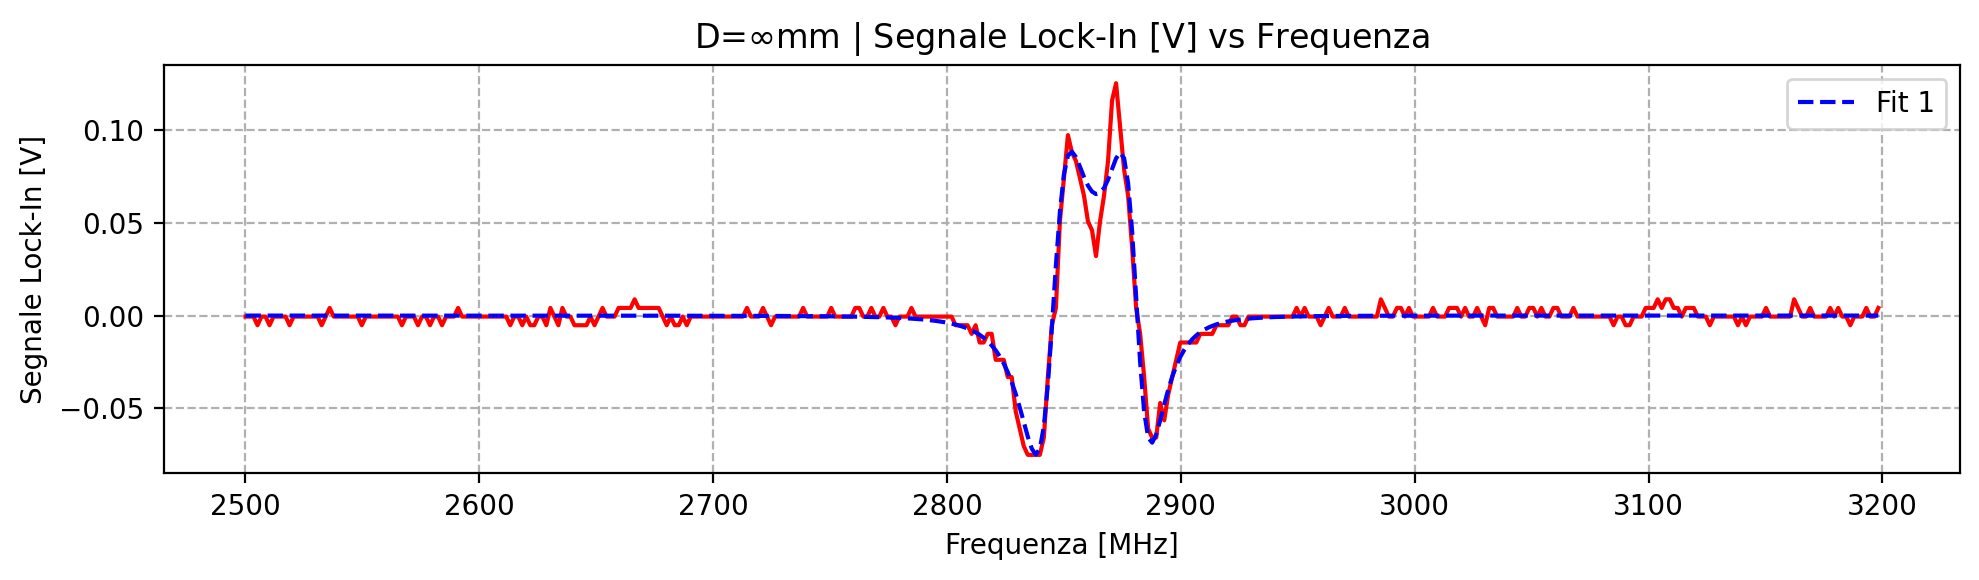

Centri:
  lockin    |    normal
2845.46725  |  2844.55630
2880.97288  |  2879.00423


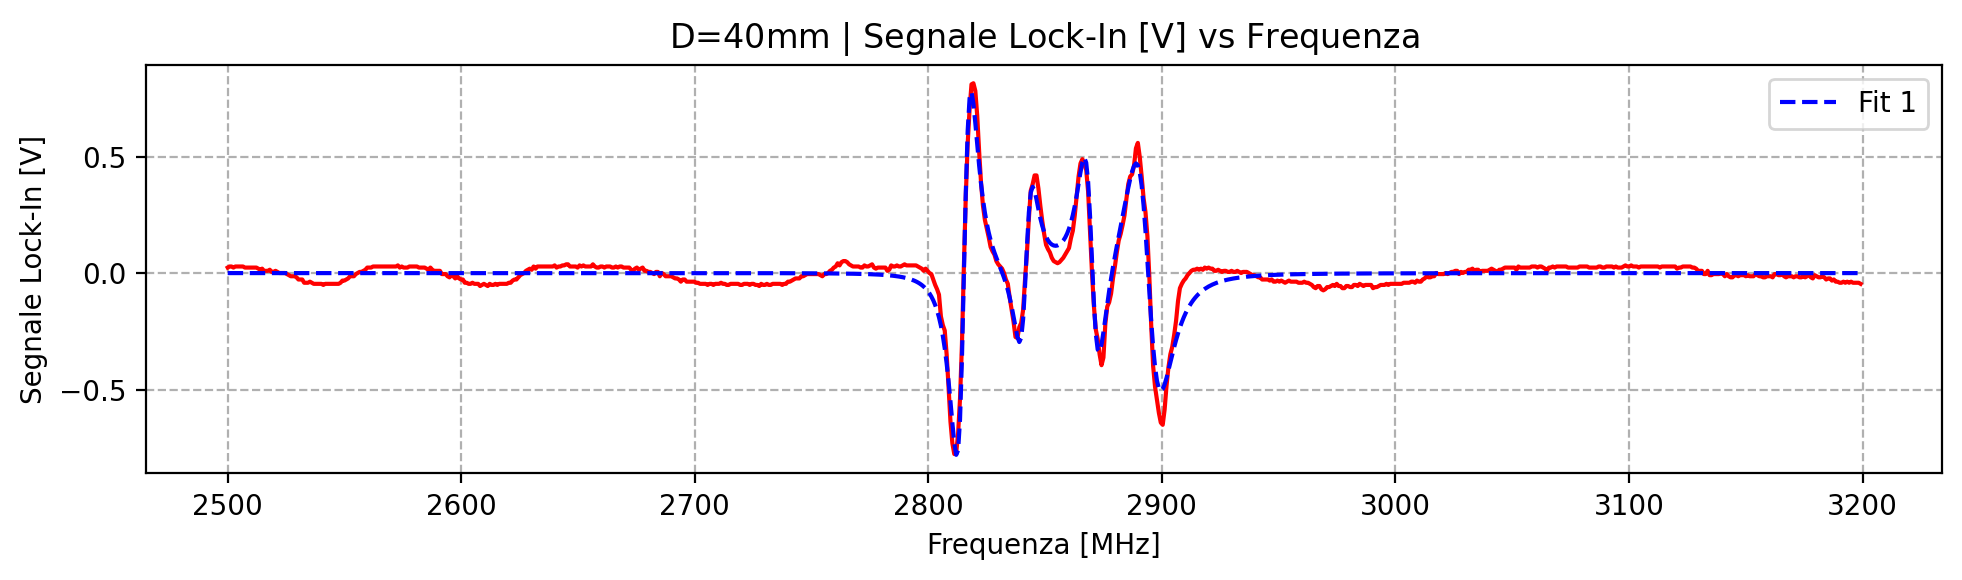

Centri:
  lockin    |    normal
2815.23390  |  2815.08272
2841.84474  |  2841.71268
2869.99354  |  2869.78206
2894.21582  |  2893.69407


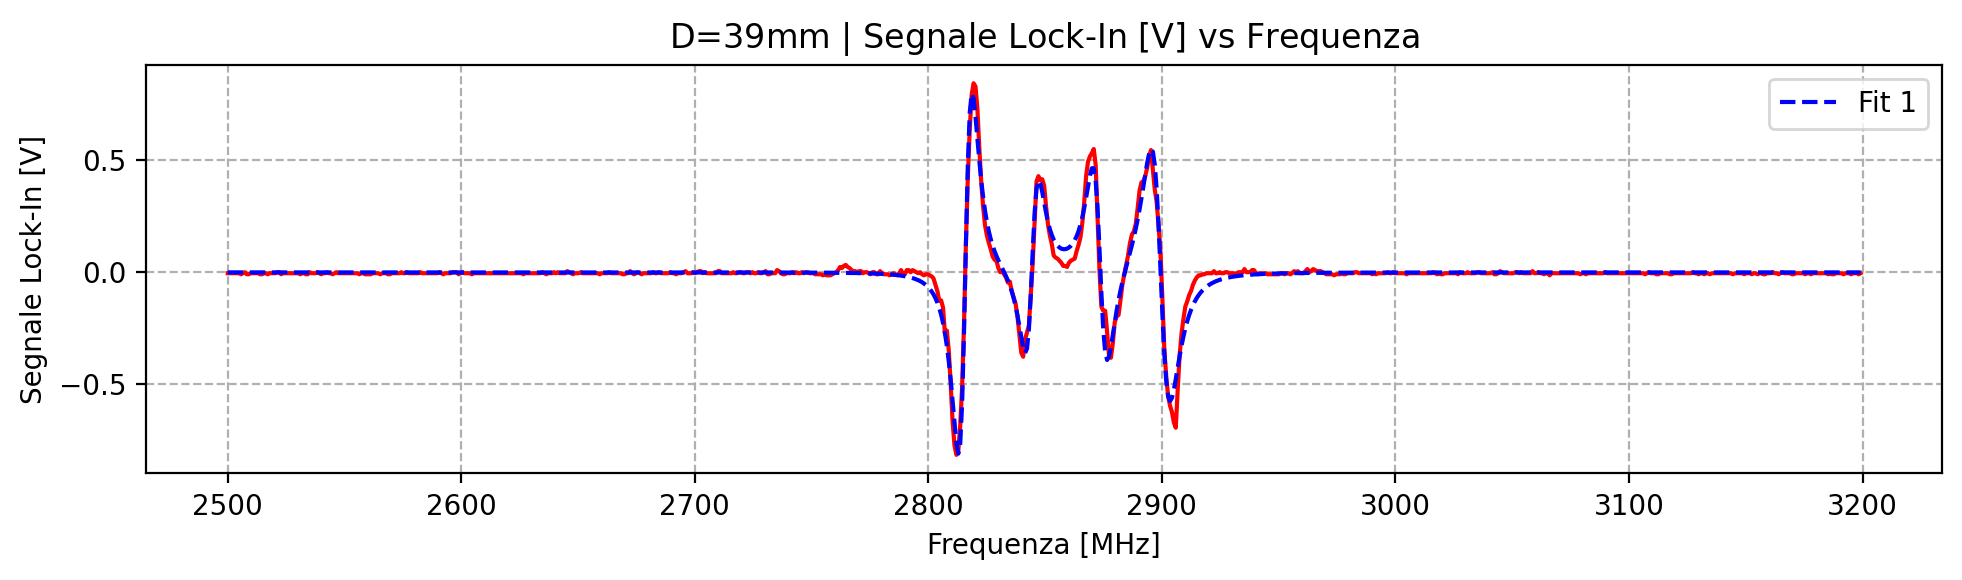

Centri:
  lockin    |    normal
2815.82995  |  2815.64465
2844.39862  |  2844.11209
2873.56248  |  2873.50805
2899.49604  |  2898.40028


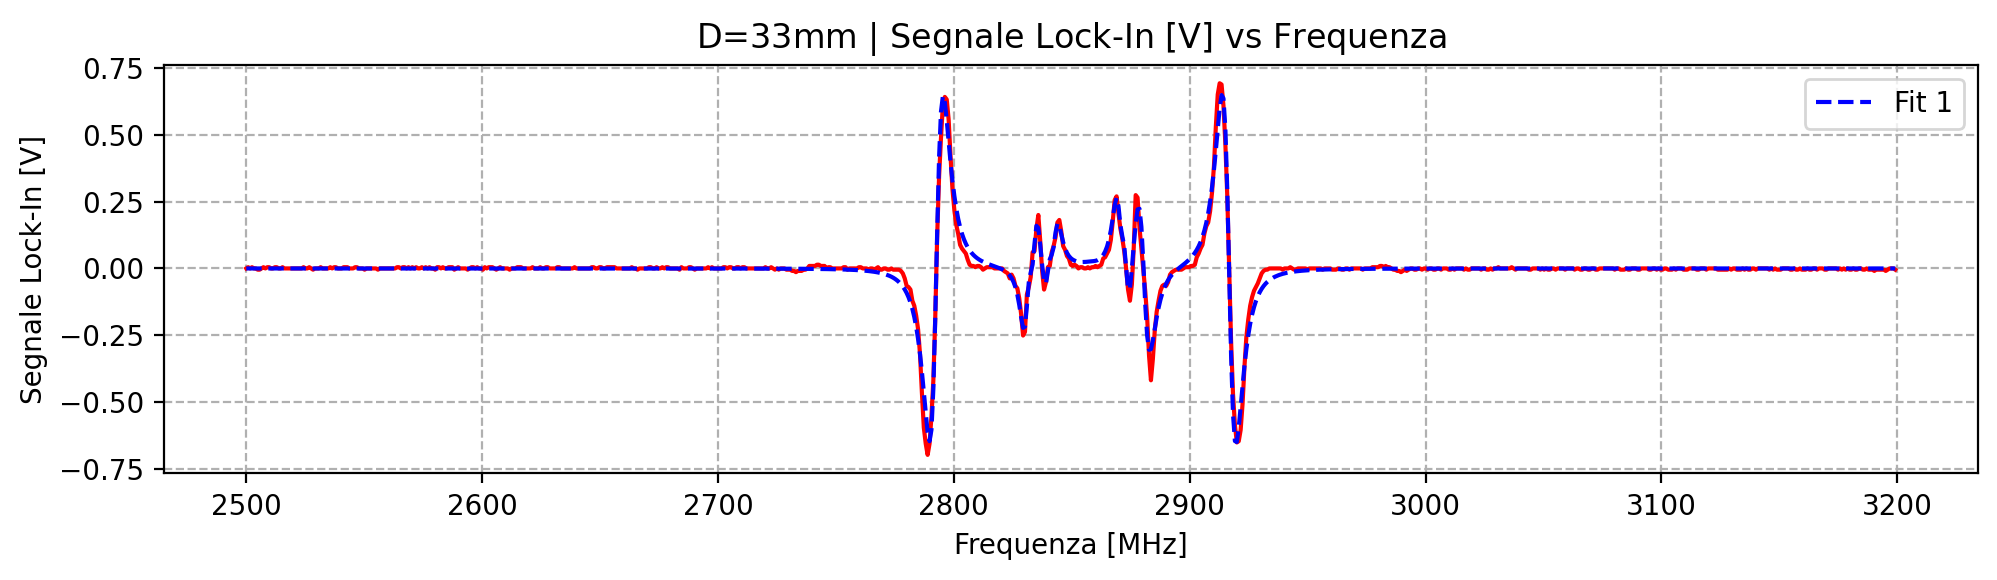

Centri:
  lockin    |    normal
2792.60534  |  2791.63047
2842.79610  |  2842.46923
2860.00006  |  ---
2839.83400  |  ---
2870.25031  |  2868.51504
2834.15182  |  2836.46923
2873.09183  |  2873.51504
2831.11155  |  2833.46923
2880.60277  |  2878.51504
2916.71661  |  2916.03925


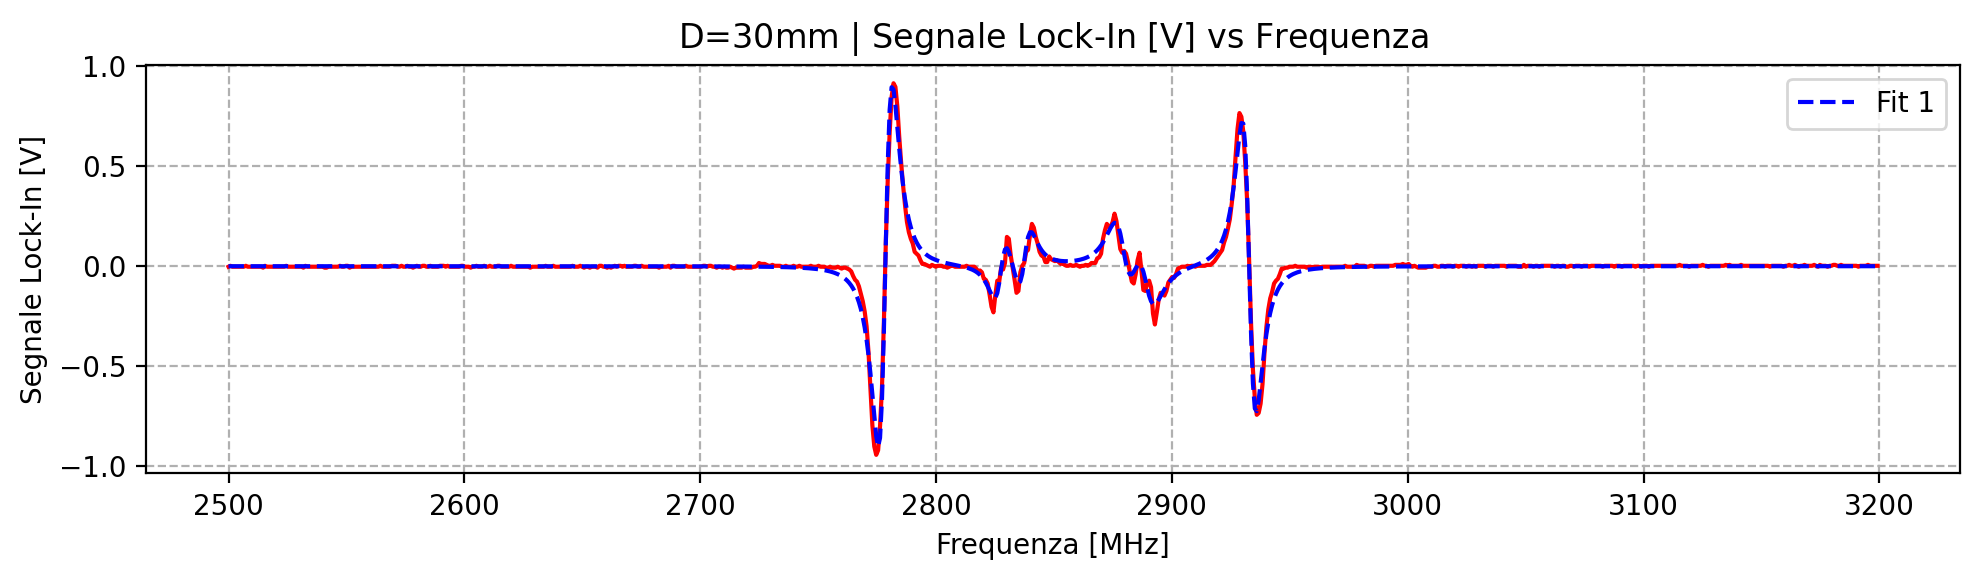

Centri:
  lockin    |    normal
2778.49198  |  2777.69641
2827.44450  |  2827.21598
2837.51901  |  2837.11169
2879.48562  |  2879.46904
2888.98527  |  2888.46762
2932.76029  |  2932.49721


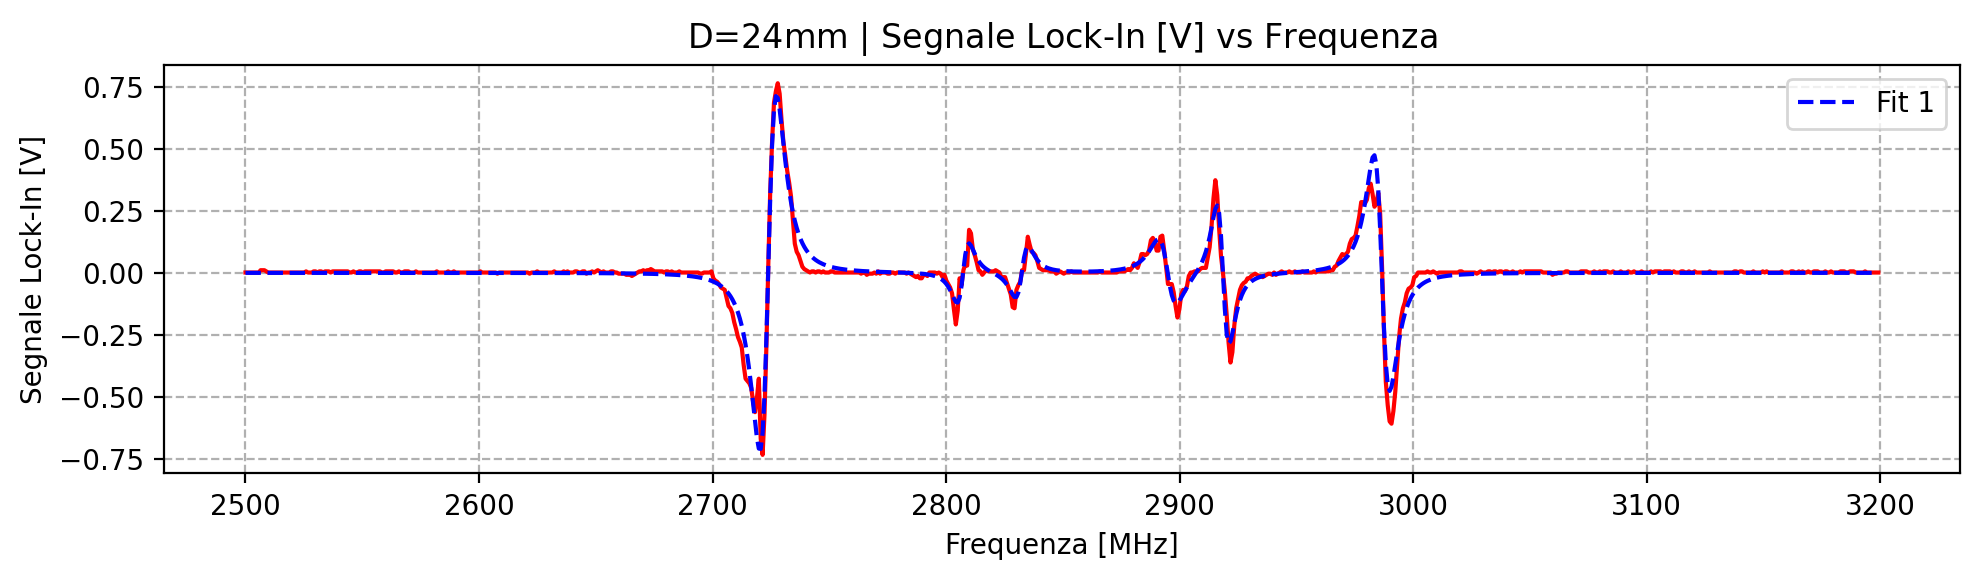

Centri:
  lockin    |    normal
2723.82310  |  2723.03471
2807.25783  |  2806.81932
2832.43492  |  2832.39144
2894.78240  |  2894.23455
2918.59188  |  2919.08097
2986.57828  |  2986.74085


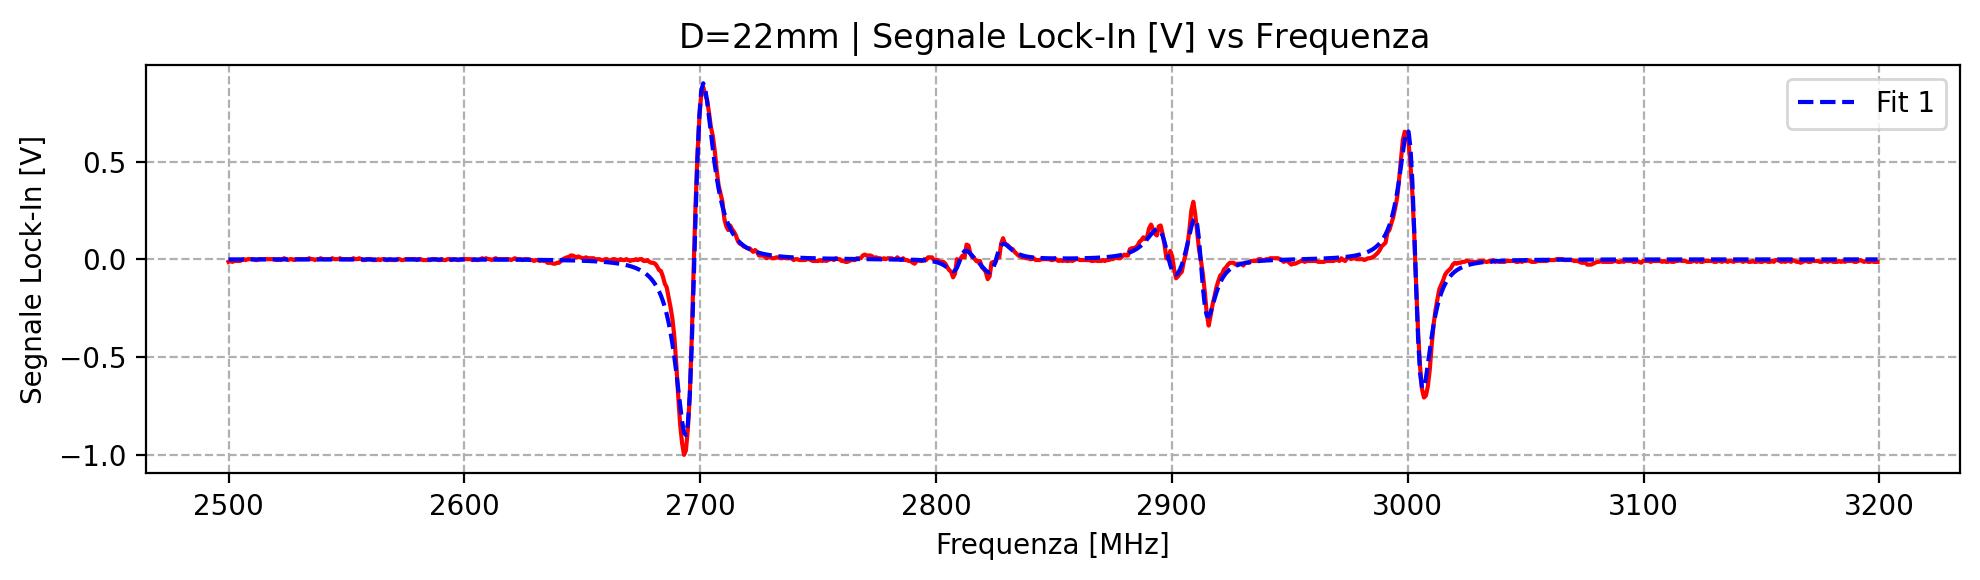

Centri:
  lockin    |    normal
2697.50917  |  2699.54723
2810.02757  |  2809.65453
2825.55303  |  2825.63927
2898.08212  |  2897.00257
2912.45518  |  2912.60723
3003.15350  |  3003.09741


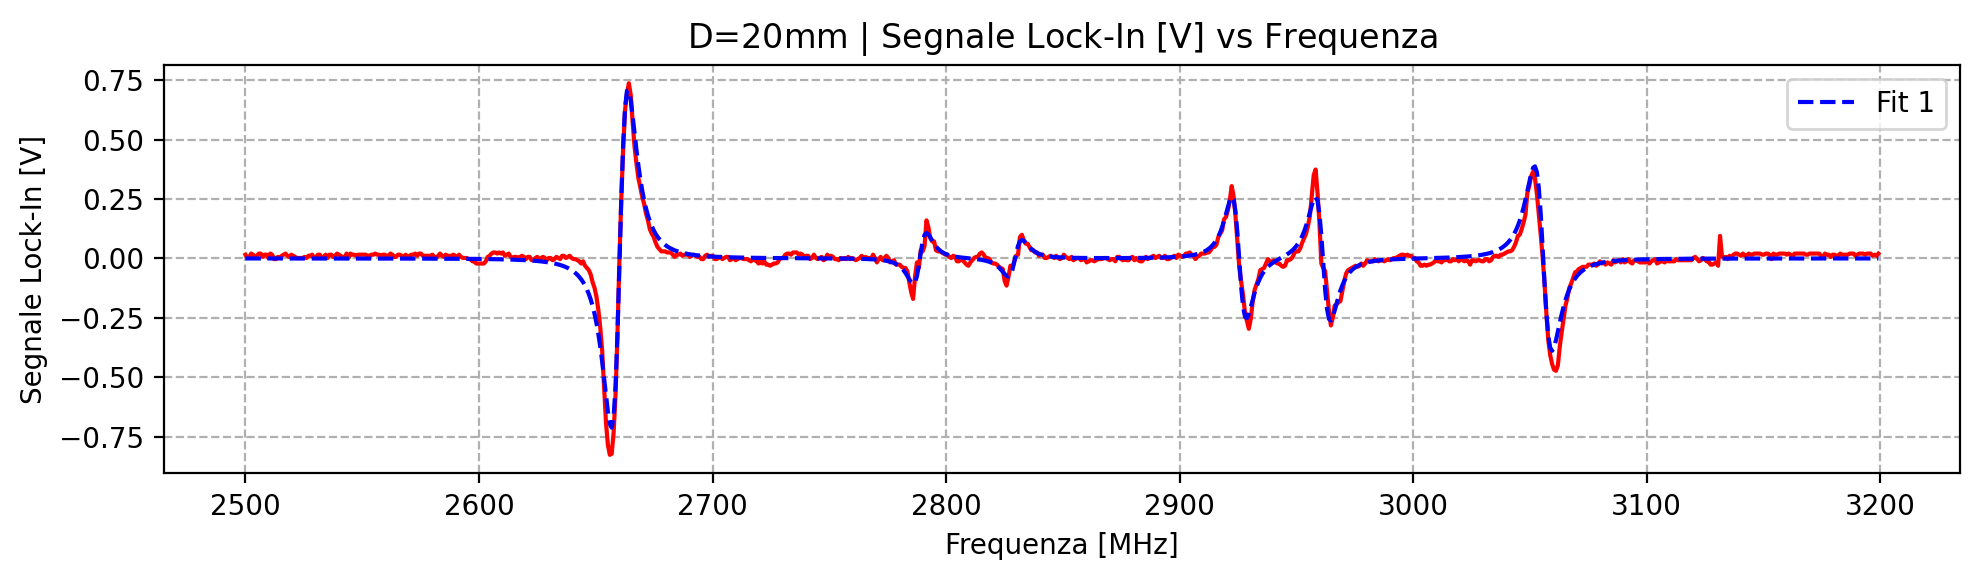

Centri:
  lockin    |    normal
2660.22030  |  2658.89145
2788.77679  |  2788.99757
2829.54593  |  2827.76605
2925.47271  |  2925.28289
2961.36722  |  2961.40860
3055.67976  |  3055.39827


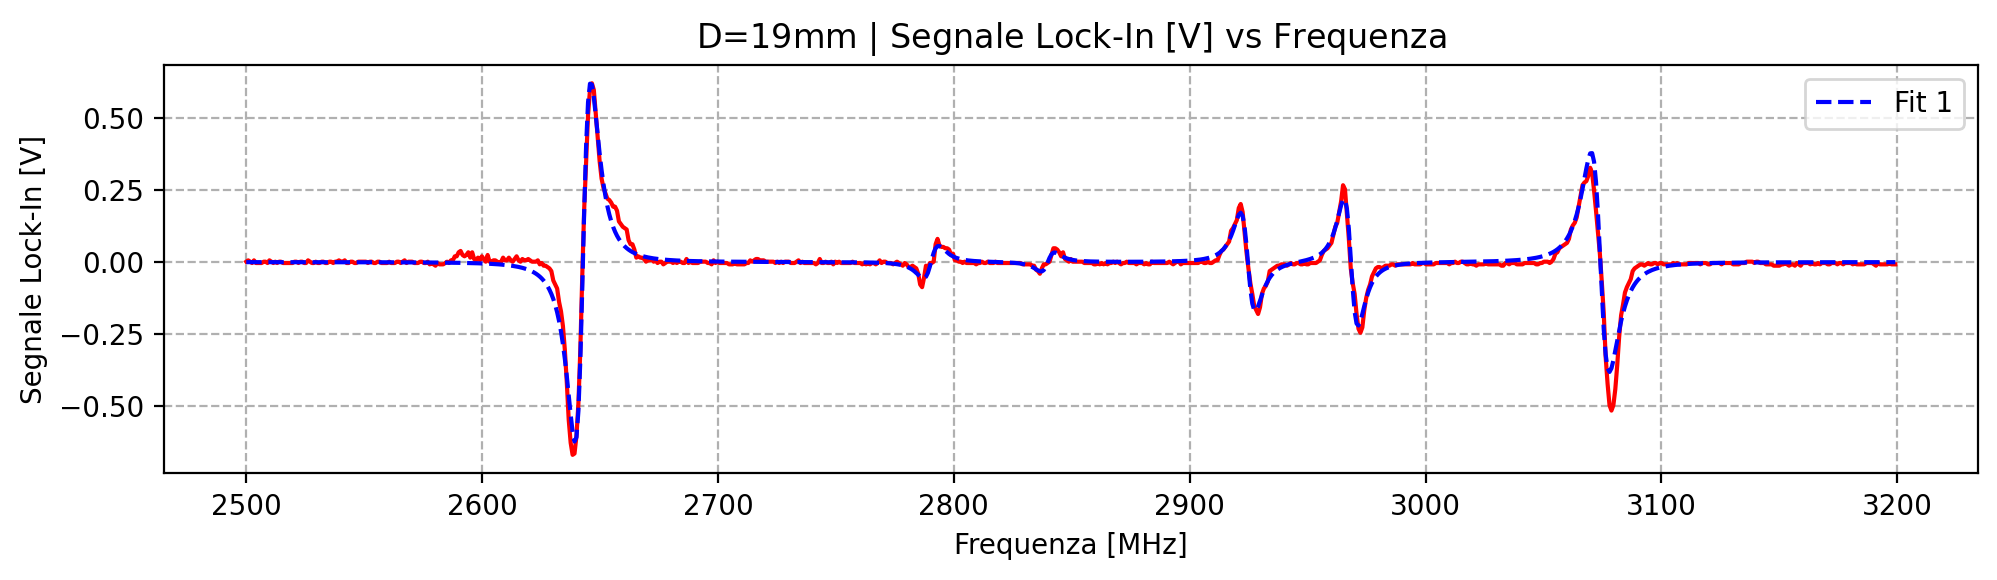

Centri:
  lockin    |    normal
2642.74105  |  2642.95991
2790.34341  |  2789.58385
2839.85712  |  2839.67311
2924.69162  |  2923.55197
2968.41433  |  2967.48125
3074.11257  |  3073.10975


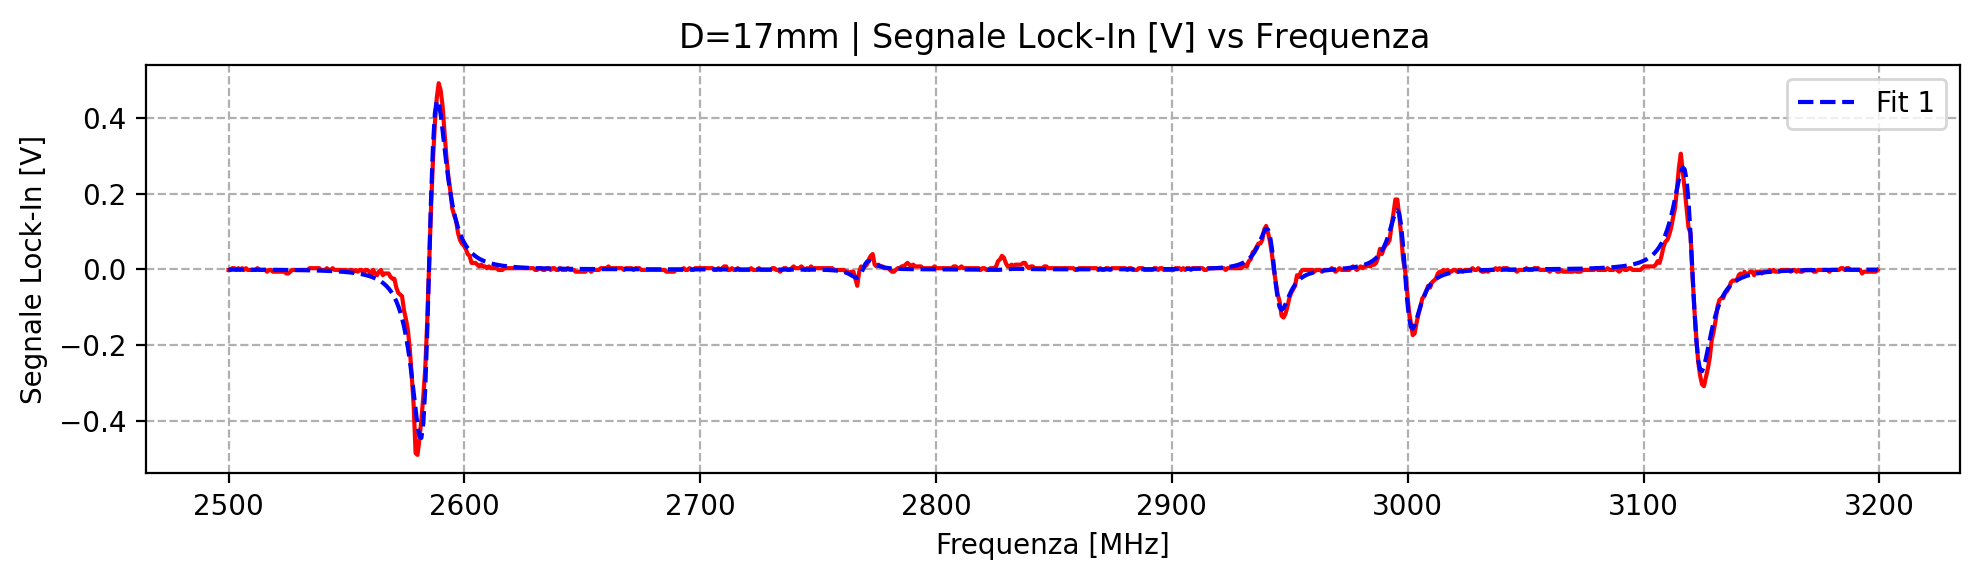

Centri:
  lockin    |    normal
2585.00988  |  2583.03775
2768.96434  |  2768.75160
2829.47545  |  2834.47545
2943.36662  |  2941.80317
2998.74525  |  2998.15610
3120.64605  |  3121.04184
9.07159411734923


In [32]:
def build_name (dist):
    return f"data/cristallo2_aligned_cleaned/odmr_dist_{dist}_cleaned.csv"

distanze = [17, 19, 20, 22, 24, 30, 33, 39, 40, 1000]
nu0s_lockin = {}
gammas_lockin = {}

# Primo loop inutile ma devo normalizzare gli spettri
massimo_assoluto = 0
for i, dist in enumerate(reversed(distanze)):
    # costruisco il nome del file
    nome = build_name(dist)
    # leggo il file e immagazzino le informazioni in un oggetto 'spettro' (dizionario)
    spettro = leggi_file_odmr(nome)
    # correggo lo spettro lock-in
    spettro = trasla_spettro_lock_in(spettro)
    # cerco il massimo assoluto
    if np.max(np.abs(spettro['lock'])) > massimo_assoluto:
        massimo_assoluto = np.max(np.abs(spettro['lock']))

# Nel loop:
for i, dist in enumerate(reversed(distanze)):
    nu0s_lockin[dist] = []
    gammas_lockin[dist] = []
    
     # costruisco il nome del file
    nome = build_name(dist)
    # leggo il file e immagazzino le informazioni in un oggetto 'spettro' (dizionario)
    spettro = leggi_file_odmr(nome)
    # correggo lo spettro lock-in
    spettro = trasla_spettro_lock_in(spettro)
    # normalizzo lo spettro lock-in
    spettro['lock'] = spettro['lock'] / massimo_assoluto
    
    # Crea la funzione di fit specifica per questo numero di deep
    # HACK: a 33mm il lock-in vede una separazione in più! vanno aggiunti due deep
    if dist == 33:
        nu0s[dist] = nu0s[dist][:1] + [nu0s[dist][1] + 3, nu0s[dist][2] - 5] + nu0s[dist][1:]
        gammas[dist] = gammas[dist][:1] + [gammas[dist][1], gammas[dist][1]] + gammas[dist][1:]
         
    # quanti deep mi aspetto?
    N_deeps = len(nu0s[dist]) 
    fit_func = make_N_derivate_lorentziane(N_deeps)
    
    # Parametri iniziali (SENZA N_deeps all'inizio)
    p0 = []
    low = []
    upp = []
    for j in range(N_deeps):
        p0 += [5, gammas[dist][j], nu0s[dist][j]]
        low += [0, gammas[dist][j]/1.5, nu0s[dist][j] - 5]
        upp += [np.inf, gammas[dist][j]*1.5, nu0s[dist][j] + 5]

    # fitto lo spettro lock-in
    popt, pcov = curve_fit(fit_func, spettro['freq'], spettro['lock'], p0=p0, bounds=(low, upp), maxfev=10000)
    # plotto lo spettro
    plot_odmr(spettro, key='lock', dist=dist, fit_curves=[(spettro['freq'], fit_func(spettro['freq'], *popt))])
    
    # printo i centri trovati
    print("Centri:")
    print("  lockin    |    normal")  
    for j in range(N_deeps):
        nu0s_lockin[dist].append(popt[3*j + 2])
        gammas_lockin[dist].append(popt[3*j + 1])
        if popt[3*j] > max_a:
            max_a = popt[3*j]
        if dist == 33 and j in [2,3]:
            print(f"{popt[3*j + 2]:.5f}  |  ---")
        else:
            print(f"{popt[3*j + 2]:.5f}  |  {nu0s[dist][j]:.5f}")

    # SALVATAGGIO DELLA MULTI-LORENTZIANA
    nome_fit = f"data/cristallo2_n_lorentzians/odmr_dist_{dist}_lorentz.csv"
    freq_data = spettro['freq']
    graph_function = make_N_lorentziane(N_deeps)
    fit_data = graph_function(spettro['freq'], *popt) / 9.07159411734923 # normalizza

    # Salva i dati in formato CSV
    with open(nome_fit, 'w') as f:
        f.write("  freq    |   fit    \n")
        f.write("----------+----------\n")
        for freq, fit_val in zip(freq_data, fit_data):
            f.write(f"{freq:9.3f} | {fit_val:8.5f}\n")
            
print(max_a)

---

# Frequenza v B

I valori di B sono presi dal fit del magnete piccolo, vedi 4-fit_magneti.ipynb

La funzione con cui interpolare è: 
$$
\nu_\pm = D \pm \sqrt{E^2+(\gamma_{fit}\cdot B_{0})^{2}}
$$
con $D=2.87\ \text{GHz}$ e $E=10\ \text{MHz}$. Poi si ricava l'angolo con:
$$
\cos{\alpha} = \frac{\gamma_{fit}}{\gamma} \implies 
\alpha = \arccos{\frac{\gamma_{fit}}{\gamma}}
$$
in cui $\gamma=\pm28\ \text{GHzT}^{-1}$

Occorre anche propagare l'errore da $\gamma_{fit}$ ad $\alpha$, usando la derivata dell'arcocoseno:
$$
\frac{d}{dx} \arccos{x} = \frac{1}{\sqrt{1-x^2}}
$$
pertanto:
$$
\sigma_\alpha = \frac{\sigma_{\gamma_{fit}}}{\gamma\sqrt{1-\left(\frac{\gamma_{fit}}{\gamma}\right)^2}}
$$

In [33]:
previsioni_B = np.array([0.01685433, 0.01270503, 0.01110222, 0.00857636, 0.00671791,
       0.00345788, 0.00255966, 0.00147035, 0.00134735, 0])
err_B = [0.02128, 0.01618, 0.01420, 0.01106, 0.00874, 0.00463, 0.00348] #... non hanno senso questi errori!

### Fit Frequenza v B

Per fare il fit non posso usare le curve organizzate in questo modo. Mi serve un'array per ogni possibile curva 'che si allarga'. Il primo punto azzurro ha due curve con i due verdi dopo, che a loro volta vanno nei due rosa. Poi solo uno dei due rosa si separa e va in entrambi i marroni, mentre il rosa superiore finisce marrone solitario più in alto.

In [34]:
r_distanze = list(reversed(distanze))
r_B = list(reversed(previsioni_B))

In [35]:
# Sicuramente due vettori sono elementari: uno ha prende il primo elemento di ciascun array, l'altro l'ultimo.
primi, ultimi = [], []
err_primi, err_ultimi = [], []
for dist in r_distanze:
    primi.append(nu0s_lockin[dist][0])
    err_primi.append(gammas_lockin[dist][0])
    ultimi.append(nu0s_lockin[dist][-1])
    err_ultimi.append(gammas_lockin[dist][-1])
# Poi ci sono i due intermedi, che prendono il secondo e il penultimo di tutti gli array, dopo il primo ovviamente.
intermedi1, intermedi2 = [], []
err_intermedi1, err_intermedi2 = [], []
intermedi1.append(nu0s_lockin[1000][0]) 
intermedi2.append(nu0s_lockin[1000][1])
err_intermedi1.append(gammas_lockin[1000][0])
err_intermedi2.append(gammas_lockin[1000][1])
for dist in r_distanze[1:]:
    intermedi1.append(nu0s_lockin[dist][1])
    intermedi2.append(nu0s_lockin[dist][-2])
    err_intermedi1.append(gammas_lockin[dist][1])
    err_intermedi2.append(gammas_lockin[dist][-2])
# Infine i due centrali. Dovrò prendere il terzo e il terzultimo elemento, 
# ma solo in quelli che hanno almeno 6 punti. Cioè il quarto indice dell'array distanze.
centrali1, centrali2 = [], []
err_centrali1, err_centrali2 = [], []
centrali1.append(nu0s_lockin[1000][0]) # per la prima distanza ci sono solo due punti
centrali2.append(nu0s_lockin[1000][1])
err_centrali1.append(gammas_lockin[1000][0])
err_centrali2.append(gammas_lockin[1000][1])
for dist in r_distanze[1:4]:
    centrali1.append(nu0s_lockin[dist][1])
    centrali2.append(nu0s_lockin[dist][-2])
    err_centrali1.append(gammas_lockin[dist][1])
    err_centrali2.append(gammas_lockin[dist][-2])
for dist in r_distanze[4:]:
    centrali1.append(nu0s_lockin[dist][2])
    centrali2.append(nu0s_lockin[dist][-3])
    err_centrali1.append(gammas_lockin[dist][2])
    err_centrali2.append(gammas_lockin[dist][-3])

### Plot e Fit

In [36]:
list_gamma_fit = []
list_err_gamma_fit = []
popt_array = []

In [37]:
def funzione_fit_plus(B, gamma_fit, D):
    # D e E sarebbero fissi, ma gli lasciamo un minimo di libertà
    E_quadro = 100
    return D + np.sqrt(E_quadro + (gamma_fit*B)**2)
def funzione_fit_minus(B, gamma_fit, D):
    # Per le curve che scendono
    E_quadro = 100
    return D - np.sqrt(E_quadro + (gamma_fit*B)**2)

# le curve che salgono hanno il più, quelle che scendono il meno (plus=False)
def fit_plot(B, freq, err_f, gamma_fit_0, D_0, label, color, plus=True, print_fit=True):
    B = np.asarray(B)
    freq = np.asarray(freq)
    err_f = np.asarray(err_f)

    p0 = [gamma_fit_0, D_0] # gamma in GHz/T, D in MHz, E in MHz (ma plotto in MHz)
    upp = [gamma_fit_0*2, D_0+10] if plus else [gamma_fit_0*2, D_0]
    low = [gamma_fit_0/2, D_0-10] 

    popt, pcov = curve_fit(funzione_fit_plus if plus else funzione_fit_minus, B, freq, p0=p0, bounds=(low, upp), maxfev=1000000, sigma=err_f)
    perr = np.sqrt(np.diag(pcov))
    
    popt_array.append(popt)
    
    # Calcolo chi quadro ridotto
    if plus:
        fit_vals = funzione_fit_plus(B, *popt)
    else:
        fit_vals = funzione_fit_minus(B, *popt)
    residui = freq - fit_vals
    chi2 = np.sum((residui / err_f)**2)
    dof = len(B) - len(popt)
    chi2_red = chi2 / dof if dof > 0 else float('nan')

    plt.errorbar(B, freq, color=color, fmt='o', yerr=err_f, markersize=1, capsize=3)
    B_fit = np.linspace(0, 0.018, 100)
    freq_fit = funzione_fit_plus(B_fit, *popt) if plus else funzione_fit_minus(B_fit, *popt)
    plt.plot(B_fit, freq_fit, label=label, color=color)
    
    if print_fit:
        print(f"{label}: gamma_fit={popt[0]:.3f} | D={popt[1]:.3f} | chi2_red={chi2_red:.2f}")
    
    list_gamma_fit.append(popt[0])
    list_err_gamma_fit.append(perr[0])  # AGGIUNTO: salva l'errore su gamma_fit
    
    return popt, perr, chi2_red

-NV3: gamma_fit=17640.812 | D=2860.000 | chi2_red=10.28
-NV2: gamma_fit=5807.252 | D=2860.000 | chi2_red=2.40
-NV1: gamma_fit=2375.257 | D=2860.000 | chi2_red=3.34
NV1: gamma_fit=4000.000 | D=2865.000 | chi2_red=1.99
NV2: gamma_fit=8462.731 | D=2856.966 | chi2_red=2.35
NV3: gamma_fit=16303.461 | D=2865.000 | chi2_red=3.03


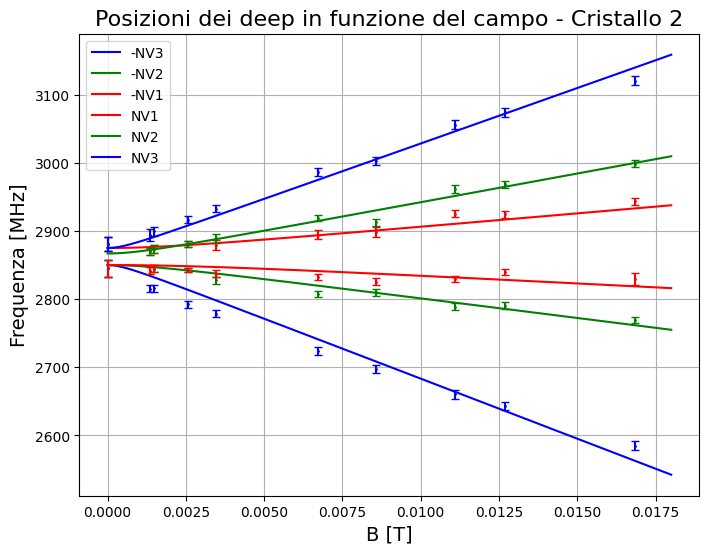

In [38]:
plt.figure(figsize=(8,6))
plt.title(f'Posizioni dei deep in funzione del campo - Cristallo 2', fontsize=16)
plt.xlabel('B [T]', fontsize=14)
plt.ylabel('Frequenza [MHz]', fontsize=14)

fit_plot(r_B, primi, err_primi, 16000, 2870,'-NV3', 'blue', plus=False)
fit_plot(r_B, intermedi1, err_intermedi1, 6500, 2870, '-NV2', 'green', plus=False)
fit_plot(r_B, centrali1, err_centrali1, 4000, 2870, '-NV1', 'red', plus=False)
fit_plot(r_B, centrali2, err_centrali2, 2000, 2855, 'NV1', 'red')
fit_plot(r_B, intermedi2, err_intermedi2, 6500, 2855, 'NV2', 'green')
fit_plot(r_B, ultimi, err_ultimi, 16000, 2855, 'NV3', 'blue')

plt.legend()
plt.grid()
plt.show()

In [39]:
for i, (gamma_f, err_gamma_f) in enumerate(zip(list_gamma_fit, list_err_gamma_fit)):
    cos_alpha = gamma_f / 28000 # gamma = 28 GHz
    alpha = np.arccos(cos_alpha)/np.pi*180
    sigma_alpha = ( 1/(28000* np.sqrt(1 - (gamma_f/28000)**2) )) * err_gamma_f
    print(f"{alpha:.2f} ± {sigma_alpha:.2f}" if i<3 else f"{-alpha:.2f} ± {sigma_alpha:.2f}")

50.95 ± 0.05
78.03 ± 0.02
85.13 ± 0.02
-81.79 ± 0.02
-72.41 ± 0.02
-54.39 ± 0.03


---

## Grafico con spettro odmr e lockin

qui mettiamo un bel grafico composto da due plot quello sopra odmr e quello sotto lockin 

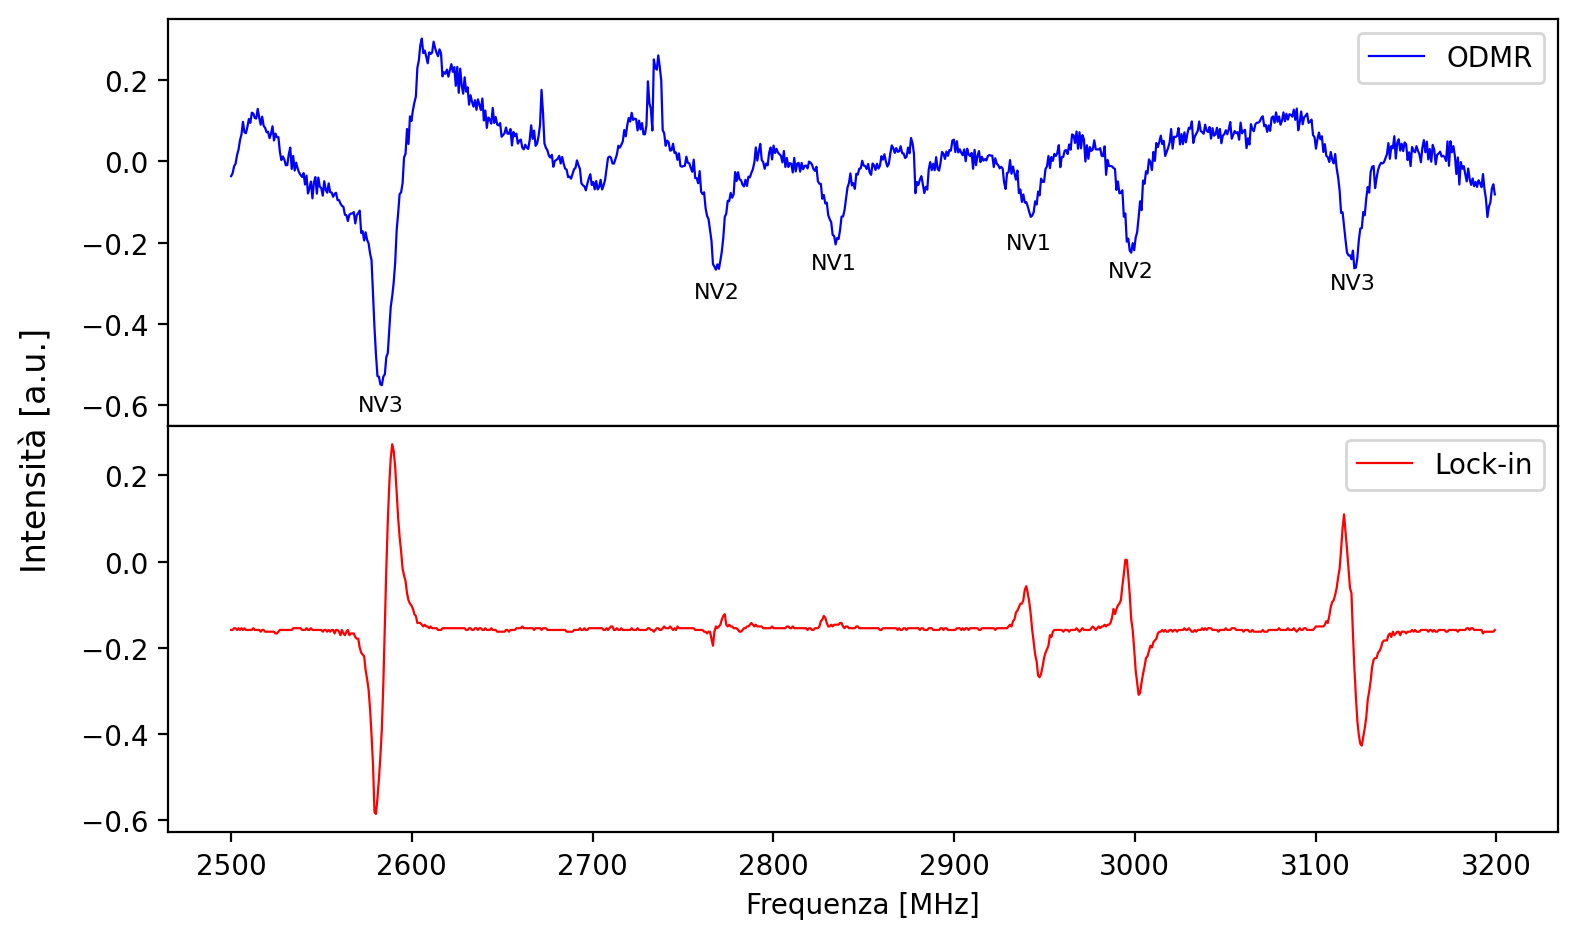

In [48]:
data = np.loadtxt("data/cristallo2_aligned_cleaned/odmr_dist_17_cleaned.csv", delimiter='|', skiprows=2)
x_od = data[:, 0]
y_od = data[:, 2]
y_lock = data[:, 3]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 5), sharex=True, gridspec_kw={'hspace': 0.0}, dpi=200)
fig.supylabel('Intensità [a.u.]')

# ODMR (sopra)
ax1.plot(x_od, y_od, 'b-', label='ODMR', linewidth=0.8)
# ax1.grid(True, alpha=0.3)
ax1.set_ylim(-0.65, 0.35)
ax1.legend(loc='best')

# --- Etichette picchi su ax1 (INSERIRE QUI LE COORDINATE) ---
# Sostituisci np.nan con le coordinate (x,y) del picco e il testo desiderato
peaks = [
    {"x": 2583, "y": -0.6, "text": "NV3"},
    {"x": 2769, "y": -0.32, "text": "NV2"},
    {"x": 2834, "y": -0.25, "text": "NV1"},
    {"x": 2942, "y": -0.2, "text": "NV1"},
    {"x": 2998, "y": -0.27, "text": "NV2"},
    {"x": 3121, "y": -0.3, "text": "NV3"},
]

# Stile etichette (solo testo)
txt_off = (8, 0)  # offset in punti (dx, dy) rispetto al picco
bbox_kw = dict(boxstyle='round,pad=0.2', facecolor='white', edgecolor='none', alpha=0.75)

for p in peaks:
    x, y, t = p["x"], p["y"], p["text"]
    if not (np.isnan(x) or np.isnan(y)):
        ax1.annotate(
            t, xy=(x, y), xycoords='data',
            xytext=txt_off, textcoords='offset points',
            ha='right', va='center', fontsize=8,
            bbox=bbox_kw  # nessuna freccia, nessun marker
        )
        
        
# --- fine etichette ---

# Lock-in (sotto)
# Se vuoi scalare come prima, usa: y_lock * max_a
ax2.plot(x_od, y_lock, 'r-', label='Lock-in', linewidth=0.8)
ax2.set_xlabel('Frequenza [MHz]')
#ax2.grid(True, alpha=0.3)
ax2.legend(loc='best')

#fig.suptitle('Spettro ODMR e Lock-in - Cristallo 2 - Distanza 17 mm', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()